In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chronickd20/csv_result-chronic_kidney_disease (1) (1).csv
/kaggle/input/ckdarff/chronic_kidney_disease.arff
/kaggle/input/snapshot2/Opera Snapshot_2022-11-11_202159_drive.google.com.png
/kaggle/input/kidneysnapshot/Opera Snapshot_2022-11-11_190533_drive.google.com.png


### Hello, this is our submission for the ML project: Kidney Chronic Disease.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold 
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error, r2_score
import xgboost
import warnings
warnings.filterwarnings('ignore')
# Import module

In [3]:
data=pd.read_csv('../input/chronickd20/csv_result-chronic_kidney_disease (1) (1).csv', error_bad_lines=False)

b'Skipping line 71: expected 26 fields, saw 27\nSkipping line 74: expected 26 fields, saw 27\nSkipping line 371: expected 26 fields, saw 27\n'


In [4]:
data

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,1,48,80,1.020,1,0,?,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,2,7,50,1.020,4,0,?,normal,notpresent,notpresent,...,38,6000,?,no,no,no,good,no,no,ckd
2,3,62,80,1.010,2,3,normal,normal,notpresent,notpresent,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,4,48,70,1.005,4,0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,5,51,80,1.010,2,0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,396,55,80,1.020,0,0,normal,normal,notpresent,notpresent,...,47,6700,4.9,no,no,no,good,no,no,notckd
393,397,42,70,1.025,0,0,normal,normal,notpresent,notpresent,...,54,7800,6.2,no,no,no,good,no,no,notckd
394,398,12,80,1.020,0,0,normal,normal,notpresent,notpresent,...,49,6600,5.4,no,no,no,good,no,no,notckd
395,399,17,60,1.025,0,0,normal,normal,notpresent,notpresent,...,51,7200,5.9,no,no,no,good,no,no,notckd


## The purpose of this project is to predict wether a patient is "ckd" positif, i.e has Kidney Chronic Disease. 
## We'll be following the CRISP Method, so we're going to start with data visualisation & business understanding.

In [5]:
#dropping id collumn 
data.drop('id', axis = 1, inplace = True)

The more we move through this project, the harder it'll be to keep track of the collumns so we'll be renaming them.

In [6]:
data.columns = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
              'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
              'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
              'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema',
              'aanemia', 'class']


In [7]:
data.head()

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


Okay, so we notice the existance of "?" in all of the features, We're gonna assume that those are missing data, so we'll convert them to NaN values so it wont disrupt plots. 

In [8]:
data=data.replace("?", np.nan)

In [9]:
data.isna().sum()

age                          9
blood_pressure              12
specific_gravity            47
albumin                     46
sugar                       49
red_blood_cells            150
pus_cell                    65
pus_cell_clumps              4
bacteria                     4
blood_glucose_random        43
blood_urea                  19
serum_creatinine            17
sodium                      85
potassium                   86
haemoglobin                 52
packed_cell_volume          70
white_blood_cell_count     105
red_blood_cell_count       130
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
peda_edema                   1
aanemia                      1
class                        0
dtype: int64

In [10]:
data.describe()

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class
count,388,385,350,351,348,247,332,393,393,354,...,327,292,267,395,395,395,396,396,396,397
unique,75,10,5,6,6,2,2,2,2,145,...,42,89,48,2,2,2,2,2,2,2
top,60,80,1.020,0,0,normal,normal,notpresent,notpresent,99,...,41,9800,5.2,no,no,no,good,no,no,ckd
freq,19,116,105,197,289,200,257,352,371,10,...,21,11,18,249,260,361,314,321,336,248


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   age                      388 non-null    object
 1   blood_pressure           385 non-null    object
 2   specific_gravity         350 non-null    object
 3   albumin                  351 non-null    object
 4   sugar                    348 non-null    object
 5   red_blood_cells          247 non-null    object
 6   pus_cell                 332 non-null    object
 7   pus_cell_clumps          393 non-null    object
 8   bacteria                 393 non-null    object
 9   blood_glucose_random     354 non-null    object
 10  blood_urea               378 non-null    object
 11  serum_creatinine         380 non-null    object
 12  sodium                   312 non-null    object
 13  potassium                311 non-null    object
 14  haemoglobin              345 non-null    o

# All of the features are labeled as objects, so we're gonna need to encode them. We'll seperate the 
# numerical & categorical values and encode them as needed.

Starting with numerical values

age, bp ,sg , al, su, bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc





age, blood_pressure, specific_gravity, albumin, sugar,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count

In [12]:
data['age'] = pd.to_numeric(data['age'], errors='coerce')
data['blood_pressure'] = pd.to_numeric(data['blood_pressure'], errors='coerce')
data['specific_gravity'] = pd.to_numeric(data['specific_gravity'], errors='coerce')
data['albumin'] = pd.to_numeric(data['albumin'], errors='coerce')
data['sugar'] = pd.to_numeric(data['sugar'], errors='coerce')
data['blood_glucose_random'] = pd.to_numeric(data['blood_glucose_random'], errors='coerce')
data['blood_urea'] = pd.to_numeric(data['blood_urea'], errors='coerce')
data['serum_creatinine'] = pd.to_numeric(data['serum_creatinine'], errors='coerce')
data['sodium'] = pd.to_numeric(data['sodium'], errors='coerce')
data['potassium'] = pd.to_numeric(data['potassium'], errors='coerce')
data['haemoglobin'] = pd.to_numeric(data['haemoglobin'], errors='coerce')
data['packed_cell_volume'] = pd.to_numeric(data['packed_cell_volume'], errors='coerce')
data['white_blood_cell_count'] = pd.to_numeric(data['white_blood_cell_count'], errors='coerce')
data['red_blood_cell_count'] = pd.to_numeric(data['red_blood_cell_count'], errors='coerce')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      388 non-null    float64
 1   blood_pressure           385 non-null    float64
 2   specific_gravity         350 non-null    float64
 3   albumin                  351 non-null    float64
 4   sugar                    348 non-null    float64
 5   red_blood_cells          247 non-null    object 
 6   pus_cell                 332 non-null    object 
 7   pus_cell_clumps          393 non-null    object 
 8   bacteria                 393 non-null    object 
 9   blood_glucose_random     354 non-null    float64
 10  blood_urea               378 non-null    float64
 11  serum_creatinine         380 non-null    float64
 12  sodium                   312 non-null    float64
 13  potassium                311 non-null    float64
 14  haemoglobin              3

In [14]:
data.head()

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


The Dtypes are correct now, numerical values are attributed the "float64" value and categorical values are "objects"

In [15]:
# Extracting categorical and numerical columns

cat_cols = [col for col in data.columns if data[col].dtype == 'object']
num_cols = [col for col in data.columns if data[col].dtype != 'object']

In [16]:
# looking at unique values in categorical columns

for col in cat_cols:
    print(f"{col} has {data[col].unique()} values\n")

red_blood_cells has [nan 'normal' 'abnormal'] values

pus_cell has ['normal' 'abnormal' nan] values

pus_cell_clumps has ['notpresent' 'present' nan] values

bacteria has ['notpresent' 'present' nan] values

hypertension has ['yes' 'no' nan] values

diabetes_mellitus has ['yes' 'no' nan] values

coronary_artery_disease has ['no' 'yes' nan] values

appetite has ['good' 'poor' nan] values

peda_edema has ['no' 'yes' nan] values

aanemia has ['no' 'yes' nan] values

class has ['ckd' 'notckd'] values



# Some Information about the features :

    1.Age(numerical)

  	  	age in years
 	2.Blood Pressure(numerical)
	       	bp in mm/Hg
 	3.Specific Gravity(nominal)
	  	sg - (1.005,1.010,1.015,1.020,1.025)
 	4.Albumin(nominal)
		al - (0,1,2,3,4,5)
 	5.Sugar(nominal)
		su - (0,1,2,3,4,5)
 	6.Red Blood Cells(nominal)
		rbc - (normal,abnormal)
 	7.Pus Cell (nominal)
		pc - (normal,abnormal)
 	8.Pus Cell clumps(nominal)
		pcc - (present,notpresent)
 	9.Bacteria(nominal)
		ba  - (present,notpresent)
 	10.Blood Glucose Random(numerical)		
		bgr in mgs/dl
 	11.Blood Urea(numerical)	
		bu in mgs/dl
 	12.Serum Creatinine(numerical)	
		sc in mgs/dl
 	13.Sodium(numerical)
		sod in mEq/L
 	14.Potassium(numerical)	
		pot in mEq/L
 	15.Hemoglobin(numerical)
		hemo in gms
 	16.Packed  Cell Volume(numerical)
 	17.White Blood Cell Count(numerical)
		wc in cells/cumm
 	18.Red Blood Cell Count(numerical)	
		rc in millions/cmm
 	19.Hypertension(nominal)	
		htn - (yes,no)
 	20.Diabetes Mellitus(nominal)	
		dm - (yes,no)
 	21.Coronary Artery Disease(nominal)
		cad - (yes,no)
 	22.Appetite(nominal)	
		appet - (good,poor)
 	23.Pedal Edema(nominal)
		pe - (yes,no)	
 	24.Anemia(nominal)
		ane - (yes,no)
 	25.Class (nominal)		
		class - (ckd,notckd)

The "ckd,notckd" values need to be transformed to binary values.

In [17]:
data['class'] = data['class'].map({'ckd': 0, 'notckd': 1})
data['class'] = pd.to_numeric(data['class'], errors='coerce')

In [18]:
print(f"class has {data['class'].unique()} values\n")

class has [0 1] values



## EDA & Data Understanding

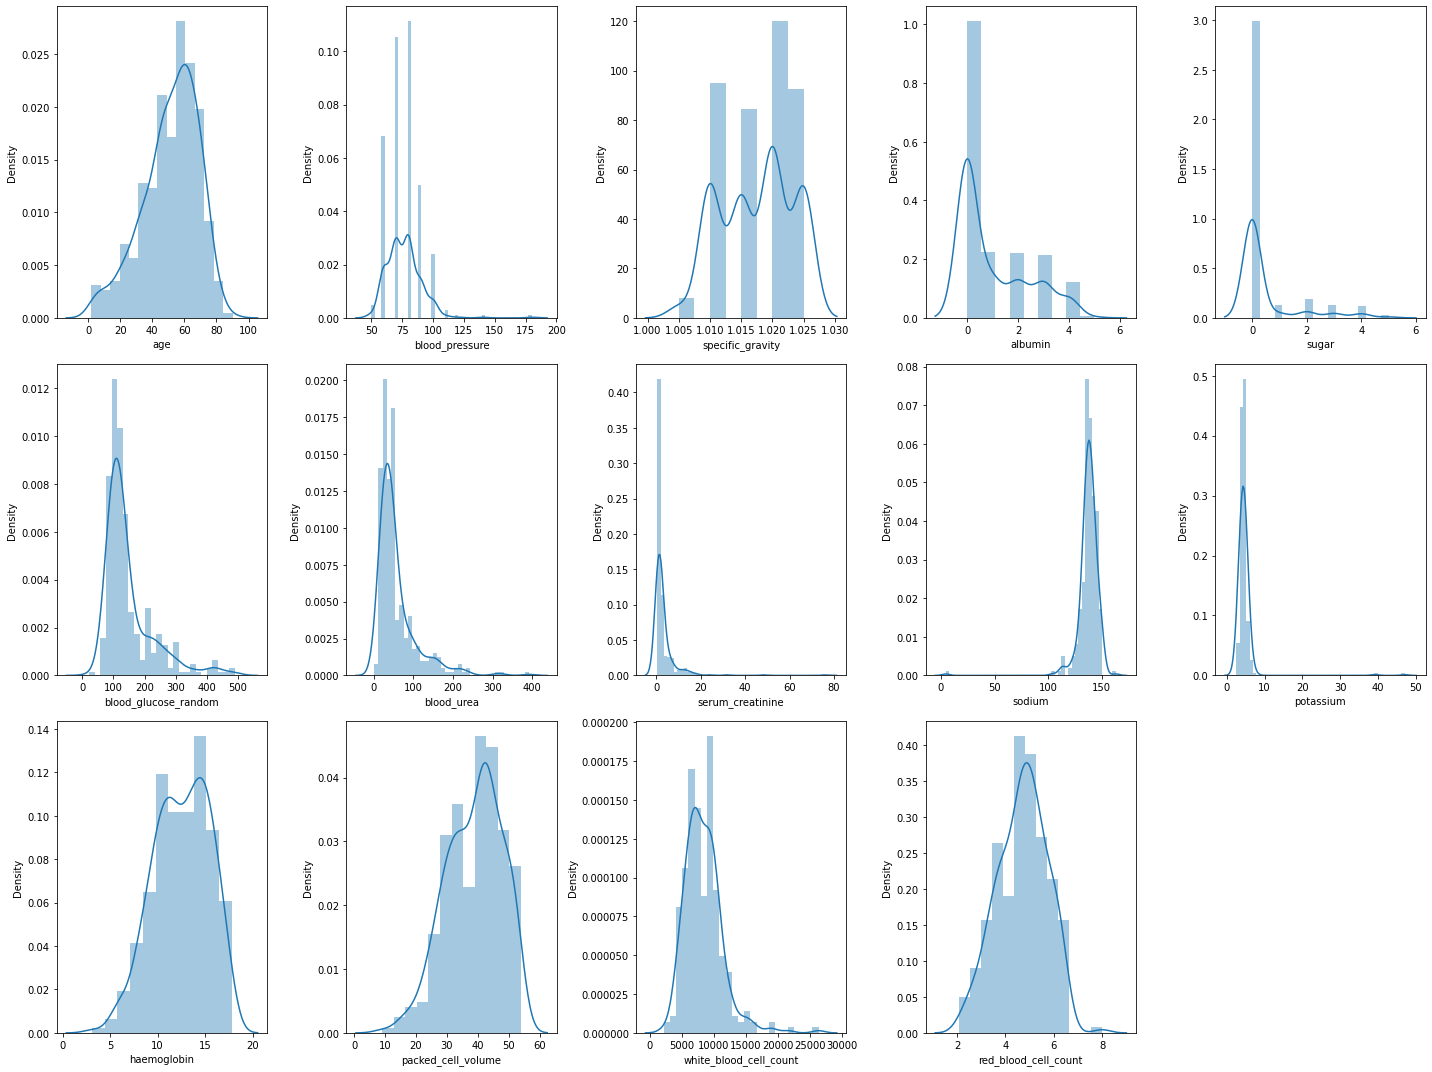

In [19]:
# checking numerical features distribution

plt.figure(figsize = (20, 15))
plotnumber = 1

for column in num_cols:
    if plotnumber <= 14:
        ax = plt.subplot(3, 5, plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

From these plots, we notice obvious skewness i.e. the data distribution is either mostly to the left side or right side for example: potassium, sodium, blood pressure,sugar.
One can use the techniques like Log transformation, square-root transformation or something know as the box-cox transformation to remove the skewness.

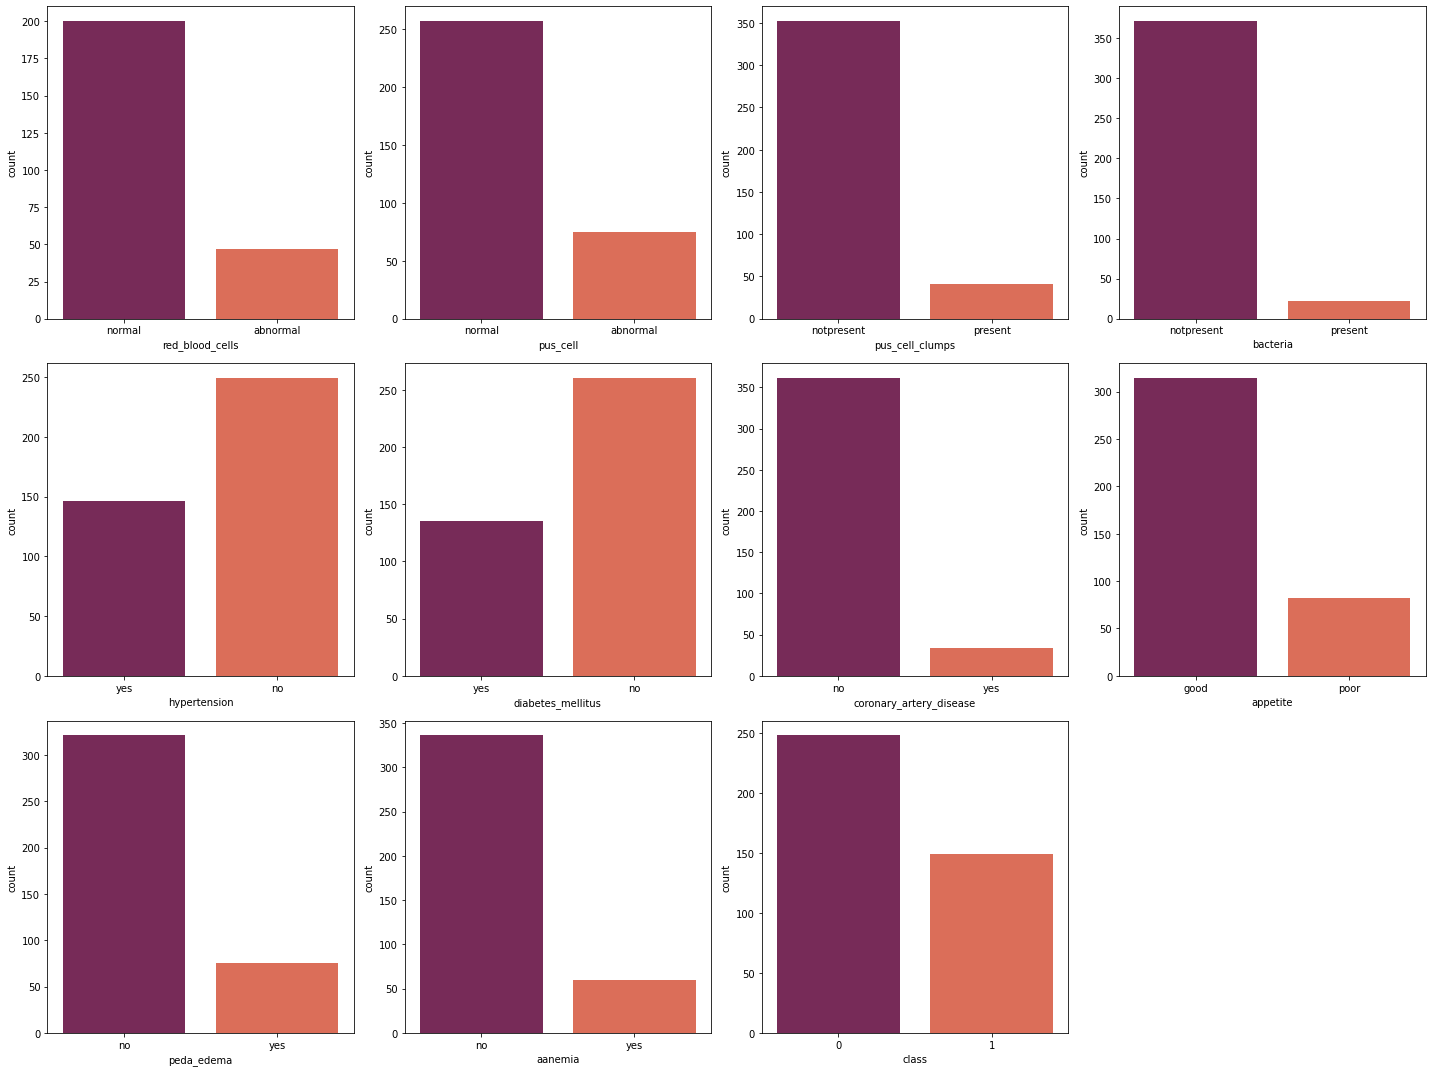

In [20]:
# looking at categorical columns

plt.figure(figsize = (20, 15))
plotnumber = 1

for column in cat_cols:
    if plotnumber <= 11:
        ax = plt.subplot(3, 4, plotnumber)
        sns.countplot(data[column], palette = 'rocket')
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

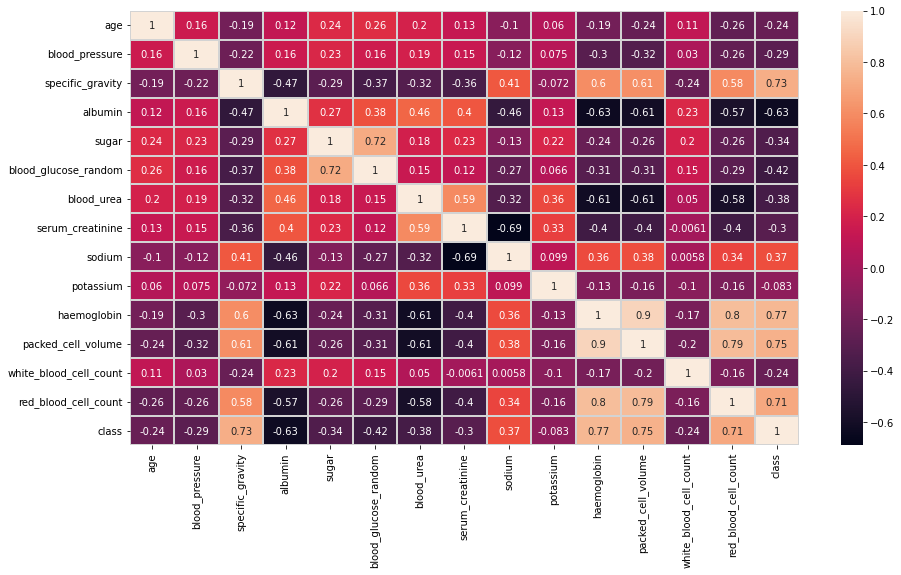

In [21]:
# heatmap of data

plt.figure(figsize = (15, 8))

sns.heatmap(data.corr(), annot = True, linewidths = 2, linecolor = 'lightgrey')
plt.show()

We can see high positif correlation between red blood cell count and the Class! also alot of inverse correlation with the black labels. 

# Article 1: A series of experiments were conducted using machine learning algorithms: SVM, KNN, decision tree, and random forest to evaluate CKD dataset.

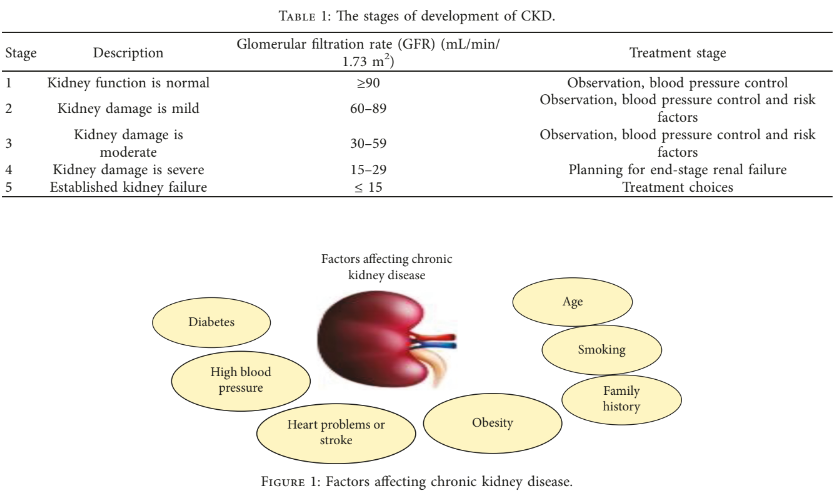

In [22]:
from IPython.display import Image
Image("../input/kidneysnapshot/Opera Snapshot_2022-11-11_190533_drive.google.com.png")

**From that image above:** 

Different factors affect the ckd distribution, such as diabetes, age, smoking etc.., however the data provided is indicative of those hidden parameters. We cant count 'smoking' but red blood count and white blood count let us know wether that person is smoking or not. 

# So understanding our data is the number 1 priority, but first, what is CKD?

CKD is a condition in which the kidneys are damaged and cannot filter blood as well as they should. Because of this, excess fluid and waste from blood remain in the body and may cause other health problems, such as heart disease and stroke.

Chronic kidney disease (CKD) has received much attention
due to its high mortality rate. Chronic diseases have become
a concern threatening developing countries, according to the
World Health Organization (WHO).

# Data plots below and insights on the different features

In [23]:
from matplotlib import style
missing=data.isna().sum().sort_values(ascending=False)
print(missing)

red_blood_cells            150
red_blood_cell_count       130
white_blood_cell_count     105
potassium                   86
sodium                      85
packed_cell_volume          70
pus_cell                    65
haemoglobin                 52
sugar                       49
specific_gravity            47
albumin                     46
blood_glucose_random        43
blood_urea                  19
serum_creatinine            17
blood_pressure              12
age                          9
bacteria                     4
pus_cell_clumps              4
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
peda_edema                   1
aanemia                      1
class                        0
dtype: int64


In [24]:
style.available


['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [25]:
style.use("fivethirtyeight")

In [26]:
data.shape

(397, 25)

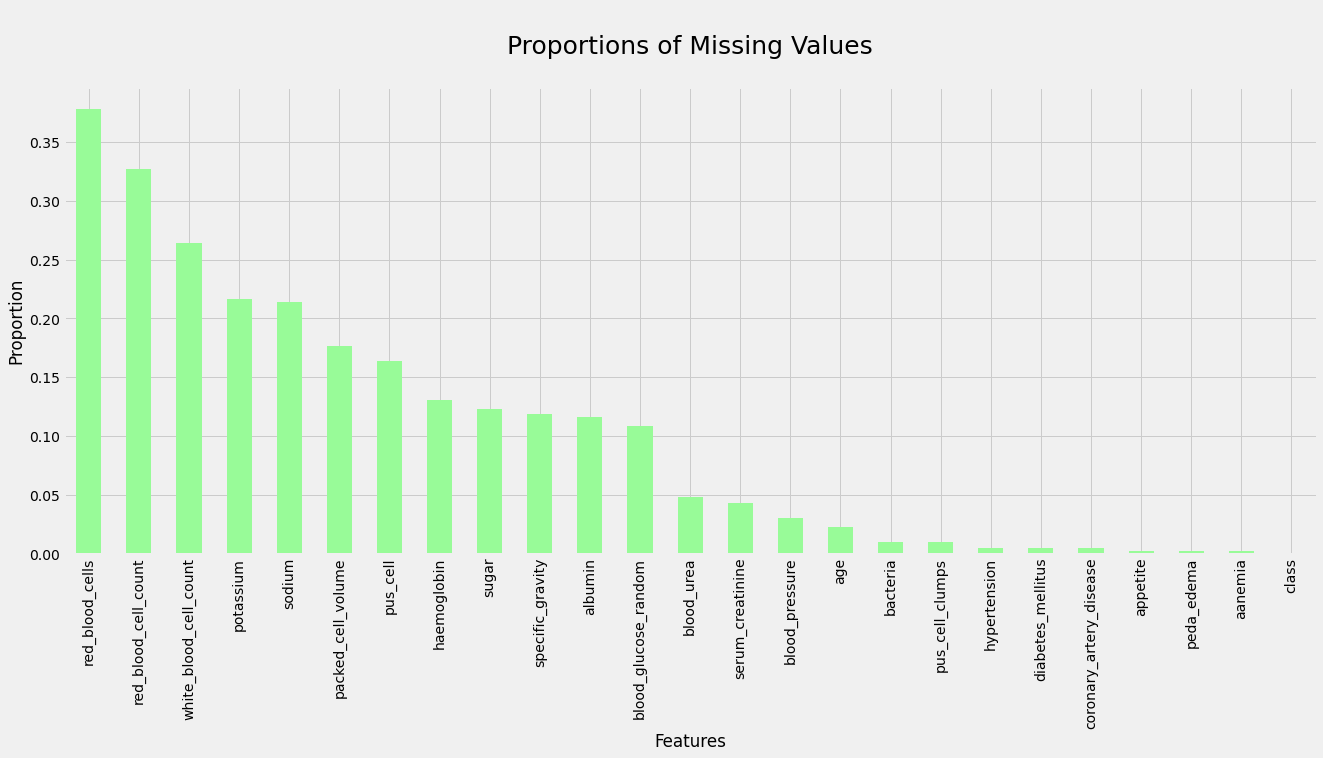

In [27]:
plt.figure(figsize=(20,8))
(missing/397).plot(kind="bar", color="palegreen") #400 is the number of patients/rows/examples/observations/lines in our data
#The "missing" variable contains the numbers of missing values, so we divide by 400 to get the proportions.
plt.title('\nProportions of Missing Values\n', fontsize=25)
plt.ylabel("Proportion")
plt.xlabel("Features")
plt.show()

Quite a **LOT** of Missing data exists here!
the red_blood_cells label presents around 36% of NaN values

## As a disclaimer, i will be replacing all NaN values with the mean value for numerical values since we're still reproducing the Article 1 work method. though, an improvement can be made here with studying each feature independently and choosing with fill method to use!

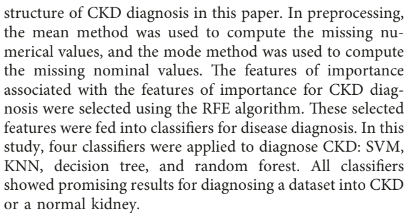

In [28]:
from IPython.display import Image
Image("../input/snapshot2/Opera Snapshot_2022-11-11_202159_drive.google.com.png")

So let's replace all missing numerical values with their mean!

**SIDE NOTE:**
Filling missing values with their mean is a **BAD** idea when dealing with a data set that presents outliers, you would be better off using the median instead.

However the article used that so, you know, who cares yeah? :p

# Univariate analysis


starting with numerical values first:

<AxesSubplot:xlabel='age', ylabel='Count'>

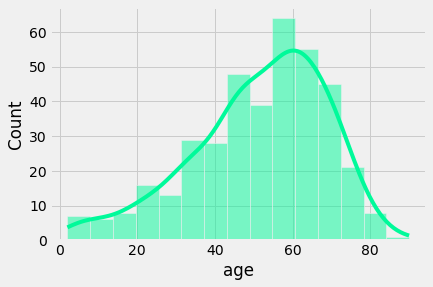

In [29]:
sns.histplot(data=data, x="age", kde=True, color="mediumspringgreen")
# kde=True means "show me a curve (courbe) with the histogram"

Histograms basically tell you which values (in this case ages) are more common in our data.
We say it shows you the "distribution" of the data.

Boxplots, boxenplots, violinplots, swarmplots, etc are other plots that also show us distributions, but in slightly different ways.
The following cell plots a histogram and a boxplot in the same graph.

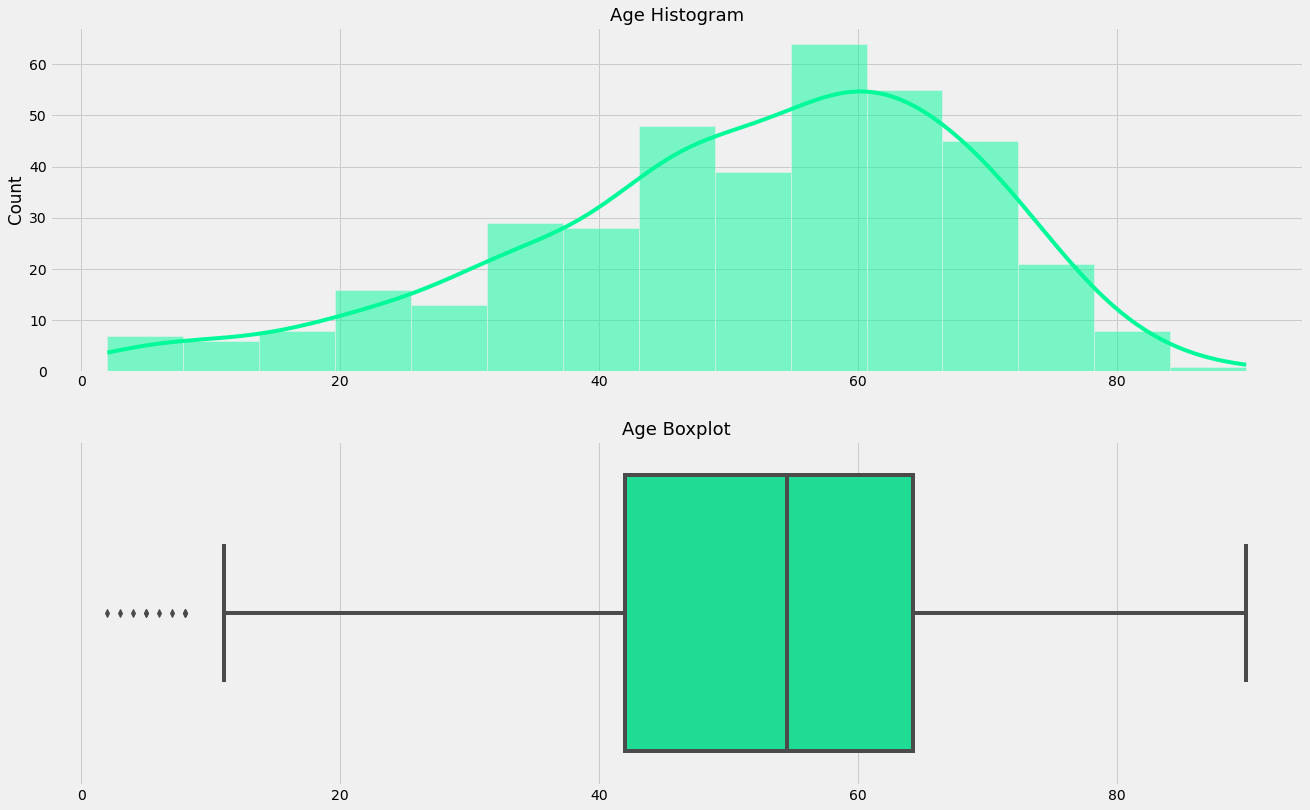

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,13)) #subplots divides your graph into 2 parts
#nrows is the number of lines in our graph
#ncols is the number of columns in our graph
#figsize is the size of the graph
sns.histplot(data=data, x="age", kde=True, color="mediumspringgreen", ax=axes[0])
sns.boxplot(data=data, x="age", color="mediumspringgreen", ax=axes[1])
axes[0].set_title("Age Histogram", fontsize=18)
axes[1].set_title("Age Boxplot", fontsize=18)
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
plt.show()
#axes[0] means the first part of the graph
#axes[1] means the second part of the graph

The boxplot shows us outliers, which are points that very far away the other points.

In [31]:
data["age"].mean()

51.45618556701031

In [32]:
data["age"].median()

54.5

As we can see, median>mean. This is because the mean value is affected by outliers while the median isnt. 

As said earlier, we'll fill the missing age values with the average/mean age.

In [33]:
data["age"].fillna(data["age"].mean(), inplace=True)


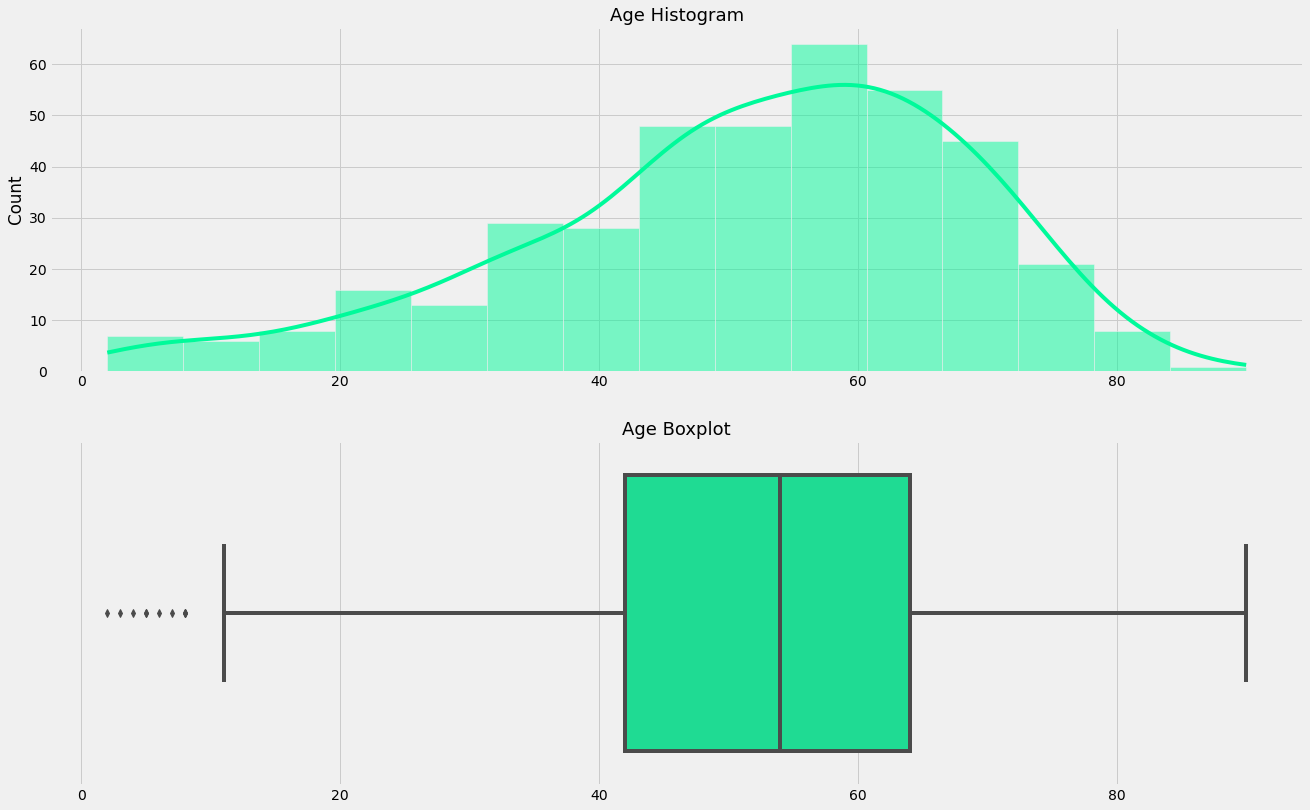

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,13))
sns.histplot(data=data, x="age", kde=True, color="mediumspringgreen", ax=axes[0])
sns.boxplot(data=data, x="age", color="mediumspringgreen", ax=axes[1])
axes[0].set_title("Age Histogram", fontsize=18)
axes[1].set_title("Age Boxplot", fontsize=18)
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
plt.show()

As we can see, there's a slight change in the histogram around the 50-60 values.

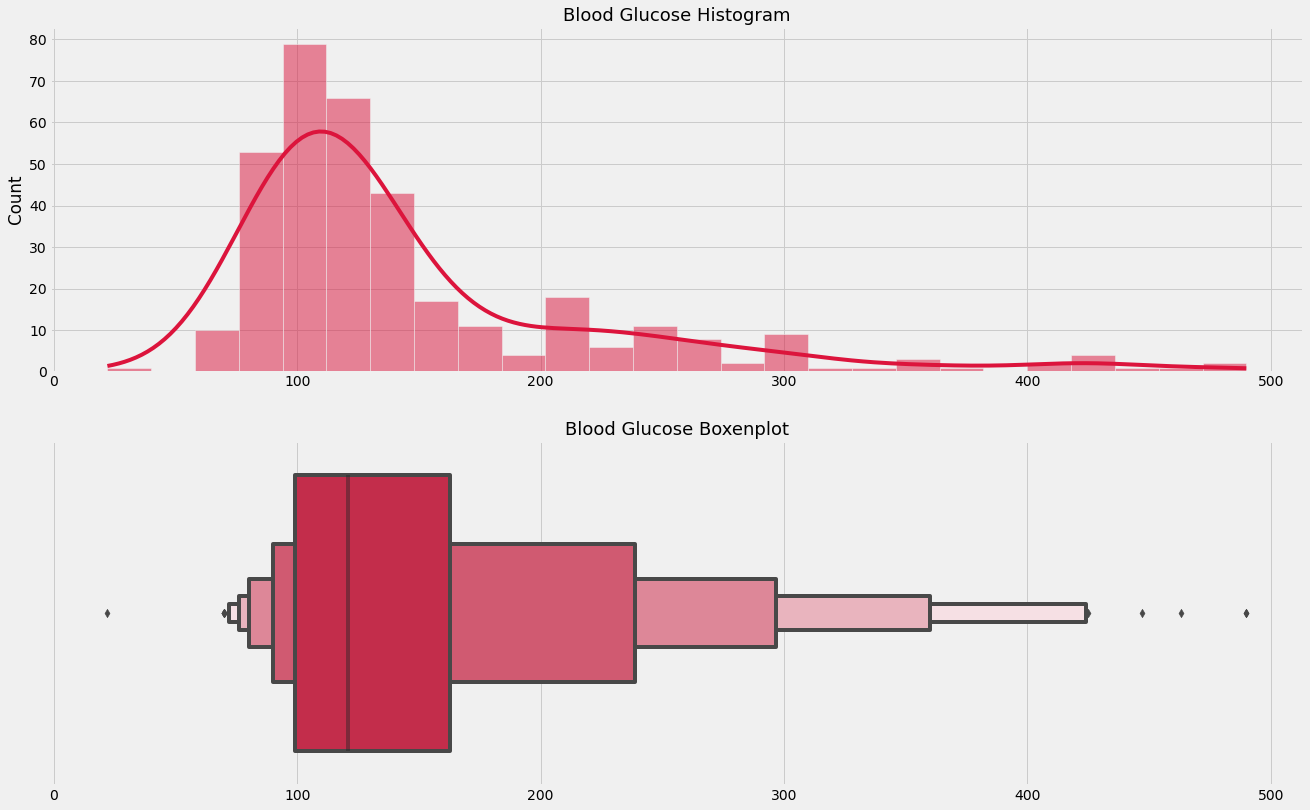

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,13))
sns.histplot(data=data, x="blood_glucose_random", kde=True, color="crimson", ax=axes[0])
sns.boxenplot(data=data, x="blood_glucose_random", color="crimson", ax=axes[1])
axes[0].set_title("Blood Glucose Histogram", fontsize=18)
axes[1].set_title("Blood Glucose Boxenplot", fontsize=18)
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
plt.show()

The histogram above is kind of pulled towards the right. We say the distribution is skewed .
Boxenplots show less outliers than boxplots.

In [36]:
data["blood_glucose_random"].mean()

147.864406779661

In [37]:
data["blood_glucose_random"].median()

121.0

The mean and the median are very far apart. This is because the distribution is skewed and has lots of outliers.

In [38]:
# filling the na values with mean 
data["blood_glucose_random"].fillna(data["blood_glucose_random"].mean(), inplace=True)

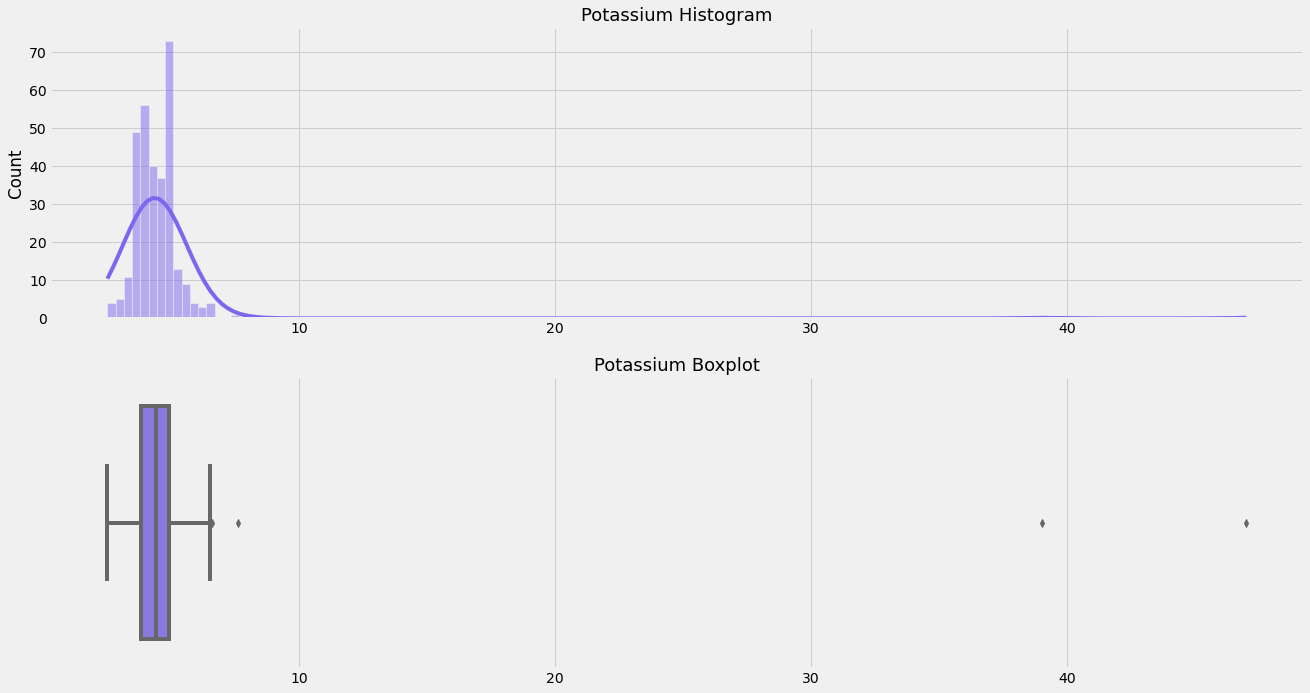

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,11))
sns.histplot(data=data, x="potassium", kde=True, color="mediumslateblue", ax=axes[0])
sns.boxplot(data=data, x="potassium", color="mediumslateblue", ax=axes[1])
axes[0].set_title("Potassium Histogram", fontsize=18)
axes[1].set_title("Potassium Boxplot", fontsize=18)
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
plt.show()

This distribution contains some very distant outliers.

In [40]:
data["potassium"].mean()

4.630868167202571

In [41]:
data["potassium"].median()

4.4

Despite the outliers, the mean and the median are almost the same.
**This is because the number of outliers is very small.**
The effect of outliers increases with their number and their distance from the center of the distribution.

In [42]:
# filling the na values with mean 
data["potassium"].fillna(data["potassium"].mean(), inplace=True)

In [43]:
data.describe()

,age,blood_pressure,specific_gravity,albumin,sugar,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,class
count,397.000000,385.000000,350.000000,351.000000,348.000000,397.000000,378.000000,380.000000,312.000000,397.000000,345.000000,327.000000,292.000000,267.000000,397.000000
mean,51.456186,76.467532,1.017429,1.017094,0.433908,147.864407,57.608995,3.088289,137.508013,4.630868,12.520870,38.822630,8404.794521,4.702247,0.375315
std,16.938112,13.711674,0.005724,1.352138,1.078316,74.861716,50.651072,5.760989,10.418992,2.829875,2.917514,8.979478,2951.168030,1.026086,0.484815
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000,0.000000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,101.000000,27.000000,0.900000,135.000000,4.000000,10.300000,32.000000,6500.000000,3.900000,0.000000
50%,54.000000,80.000000,1.020000,0.000000,0.000000,125.000000,42.000000,1.300000,138.000000,4.630868,12.600000,40.000000,8000.000000,4.800000,0.000000
75%,64.000000,80.000000,1.020000,2.000000,0.000000,150.000000,66.000000,2.800000,142.000000,4.800000,15.000000,45.000000,9800.000000,5.400000,1.000000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000,1.000000


We'll be doing the same thing for the rest of the numerical values!

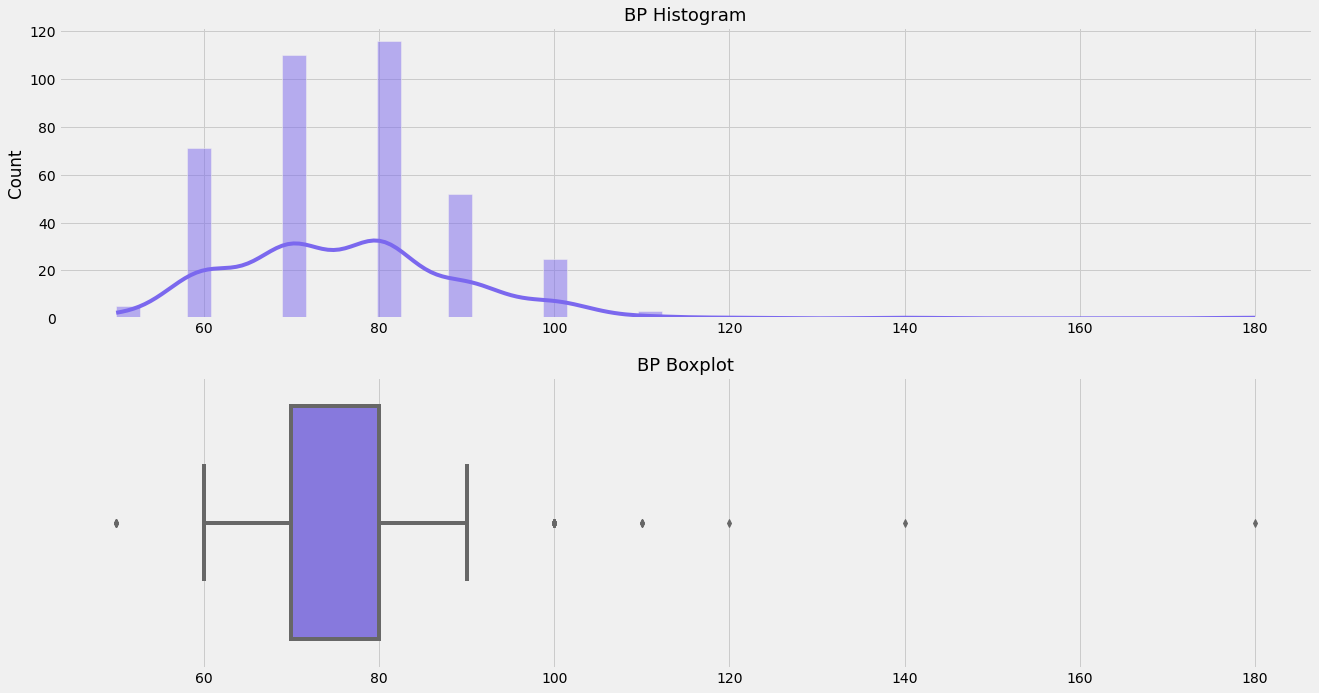

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,11))
sns.histplot(data=data, x="blood_pressure", kde=True, color="mediumslateblue", ax=axes[0])
sns.boxplot(data=data, x="blood_pressure", color="mediumslateblue", ax=axes[1])
axes[0].set_title("BP Histogram", fontsize=18)
axes[1].set_title("BP Boxplot", fontsize=18)
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
plt.show()

In [45]:
data["blood_pressure"].mean()

76.46753246753246

In [46]:
data["blood_pressure"].median()

80.0

In [47]:
data["blood_pressure"].fillna(data["blood_pressure"].mean(), inplace=True)

This is gonna take a while, so i'm gonna instantly fill all numerical values left with their mean!

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      397 non-null    float64
 1   blood_pressure           397 non-null    float64
 2   specific_gravity         350 non-null    float64
 3   albumin                  351 non-null    float64
 4   sugar                    348 non-null    float64
 5   red_blood_cells          247 non-null    object 
 6   pus_cell                 332 non-null    object 
 7   pus_cell_clumps          393 non-null    object 
 8   bacteria                 393 non-null    object 
 9   blood_glucose_random     397 non-null    float64
 10  blood_urea               378 non-null    float64
 11  serum_creatinine         380 non-null    float64
 12  sodium                   312 non-null    float64
 13  potassium                397 non-null    float64
 14  haemoglobin              3

In [49]:
data.isna().sum()

age                          0
blood_pressure               0
specific_gravity            47
albumin                     46
sugar                       49
red_blood_cells            150
pus_cell                    65
pus_cell_clumps              4
bacteria                     4
blood_glucose_random         0
blood_urea                  19
serum_creatinine            17
sodium                      85
potassium                    0
haemoglobin                 52
packed_cell_volume          70
white_blood_cell_count     105
red_blood_cell_count       130
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
peda_edema                   1
aanemia                      1
class                        0
dtype: int64

In [50]:
num_left=['blood_urea','serum_creatinine'
,'sodium','haemoglobin','packed_cell_volume',
'white_blood_cell_count','red_blood_cell_count']
for i in num_left:
       data[i].fillna(data[i].mean(), inplace=True)


Lets check the missing values again.

In [51]:
data.isna().sum()

age                          0
blood_pressure               0
specific_gravity            47
albumin                     46
sugar                       49
red_blood_cells            150
pus_cell                    65
pus_cell_clumps              4
bacteria                     4
blood_glucose_random         0
blood_urea                   0
serum_creatinine             0
sodium                       0
potassium                    0
haemoglobin                  0
packed_cell_volume           0
white_blood_cell_count       0
red_blood_cell_count         0
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
peda_edema                   1
aanemia                      1
class                        0
dtype: int64

# Categorical Values

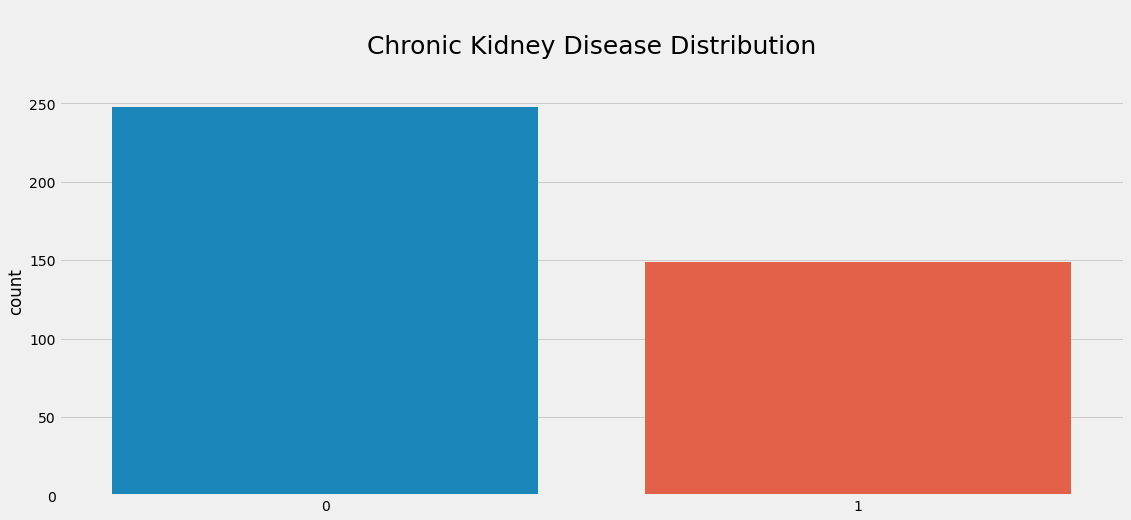

In [52]:
plt.figure(figsize=(17,7))
sns.countplot(data=data, x="class")
plt.title("\nChronic Kidney Disease Distribution\n", fontsize=25)
plt.xlabel(None) #to remove the title of the x axis
plt.show()

There is considerably more "ckd" patients than "notckd" patients.
We say this feature is slightly imbalanced.

We might need to oversample this data to reduce the overfitting.

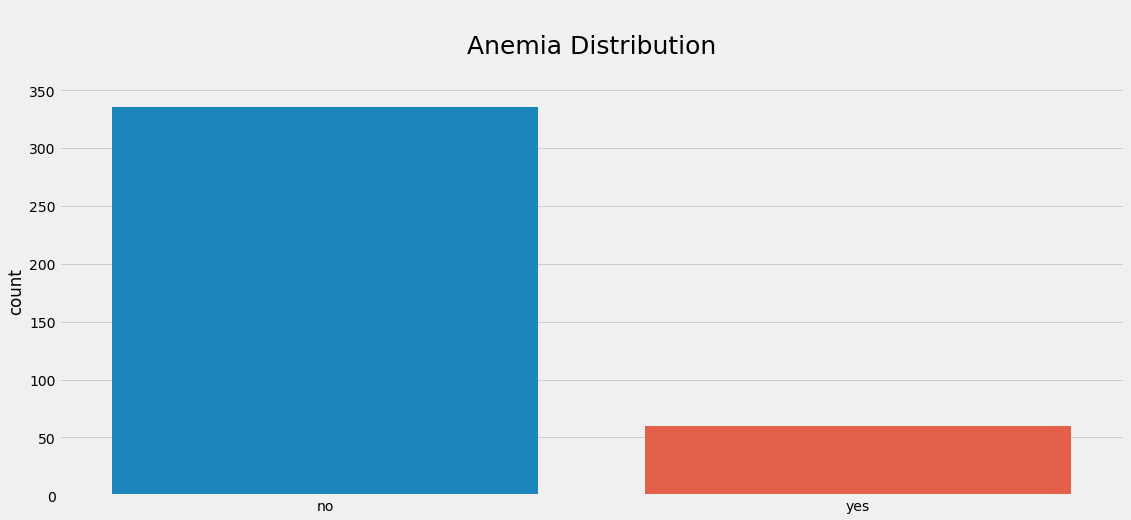

In [53]:
plt.figure(figsize=(17,7))
sns.countplot(data=data, x="aanemia")
plt.title("\nAnemia Distribution\n", fontsize=25)
plt.xlabel(None)
plt.show()

In [54]:
data["aanemia"].value_counts()

no     336
yes     60
Name: aanemia, dtype: int64

This one is very imbalanced.

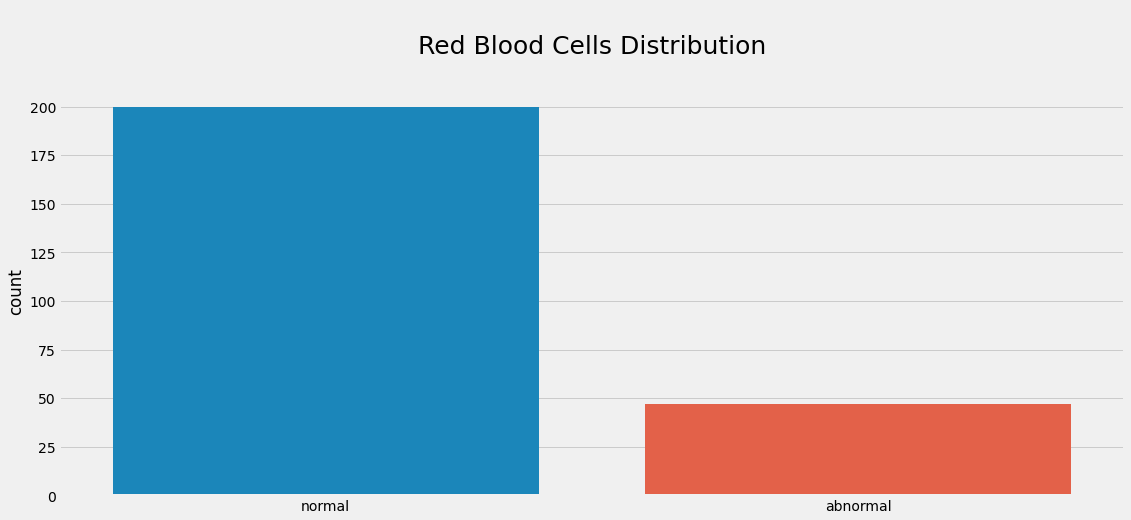

In [55]:
plt.figure(figsize=(17,7))
sns.countplot(data=data, x="red_blood_cells")
plt.title("\nRed Blood Cells Distribution\n", fontsize=25)
plt.xlabel(None)
plt.show()

In [56]:
data["red_blood_cells"].mode()

0    normal
dtype: object

As previously stated in the article, all categorical data needs to be replaced with their mdoe values.
We'll do that for these features.

In [57]:
data["red_blood_cells"].fillna(data["red_blood_cells"].mode()[0], inplace=True)


Let's see how the distribution looks after filling the missing values.

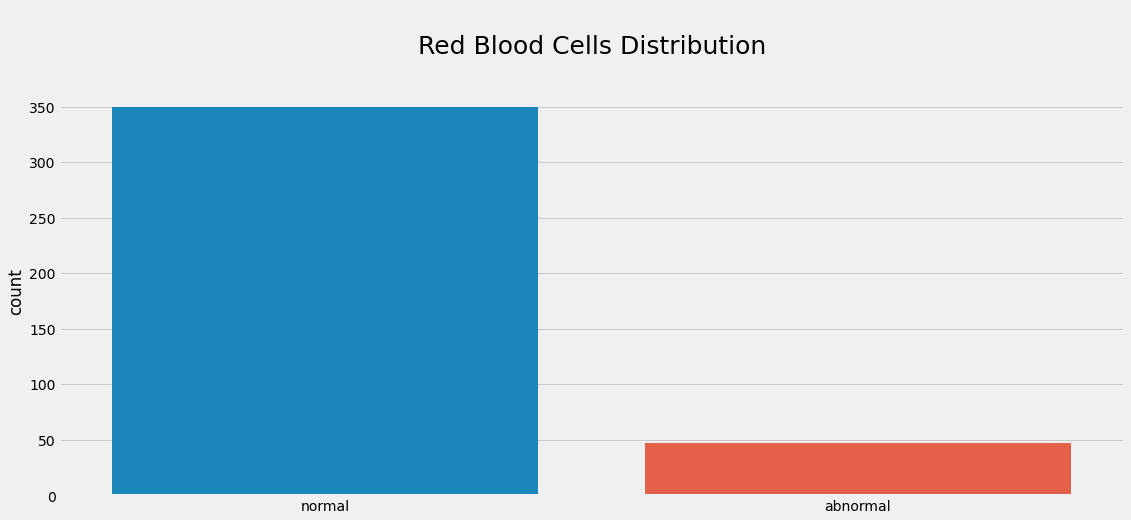

In [58]:
plt.figure(figsize=(17,7))
sns.countplot(data=data, x="red_blood_cells")
plt.title("\nRed Blood Cells Distribution\n", fontsize=25)
plt.xlabel(None)
plt.show()

Imbalanced data is a problem, especially if the target feature is very imbalanced.

Now let's see how we can fill the missing values of all features with a for loop instead of doing it one by one, same with what we did with the numerical values.

In [59]:
categorical=[]
for col in data.columns:
    if data[col].dtype=="object":
        categorical.append(col)
print(categorical)

['red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema', 'aanemia']


In [60]:
for col in data.columns:
        data[col].fillna(data[col].mode()[0], inplace=True)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      397 non-null    float64
 1   blood_pressure           397 non-null    float64
 2   specific_gravity         397 non-null    float64
 3   albumin                  397 non-null    float64
 4   sugar                    397 non-null    float64
 5   red_blood_cells          397 non-null    object 
 6   pus_cell                 397 non-null    object 
 7   pus_cell_clumps          397 non-null    object 
 8   bacteria                 397 non-null    object 
 9   blood_glucose_random     397 non-null    float64
 10  blood_urea               397 non-null    float64
 11  serum_creatinine         397 non-null    float64
 12  sodium                   397 non-null    float64
 13  potassium                397 non-null    float64
 14  haemoglobin              3

As we can see there are no missing values anymore.

# Encoding

Now let's see how we turn categorical features into numerical ones.

In [62]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [63]:
for col in categorical:
    data[col]=encoder.fit_transform(data[col])

In [64]:
data

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class
0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,121.000000,...,44.0,7800.0,5.200000,1,1,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,1,1,0,0,147.864407,...,38.0,6000.0,4.702247,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.000000,...,31.0,7500.0,4.702247,0,1,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.000000,...,32.0,6700.0,3.900000,1,0,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.000000,...,35.0,7300.0,4.600000,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.000000,...,47.0,6700.0,4.900000,0,0,0,0,0,0,1
393,42.0,70.0,1.025,0.0,0.0,1,1,0,0,75.000000,...,54.0,7800.0,6.200000,0,0,0,0,0,0,1
394,12.0,80.0,1.020,0.0,0.0,1,1,0,0,100.000000,...,49.0,6600.0,5.400000,0,0,0,0,0,0,1
395,17.0,60.0,1.025,0.0,0.0,1,1,0,0,114.000000,...,51.0,7200.0,5.900000,0,0,0,0,0,0,1


**SIDE NOTE:**
Another type of encoding possible is **One Hot Encoding**, It would be useful here since all categorical features only present 2 values, so we wont be reducing dimensions.

Also no need for that either since the article didnt use it.

# Multivariate Analysis

Relationships between multiple features

Two features require 2-dimensional plots to study.
Although we can't make plots in (for example) 26 dimensions, there are some tricks we can use to visualize high dimensional data.

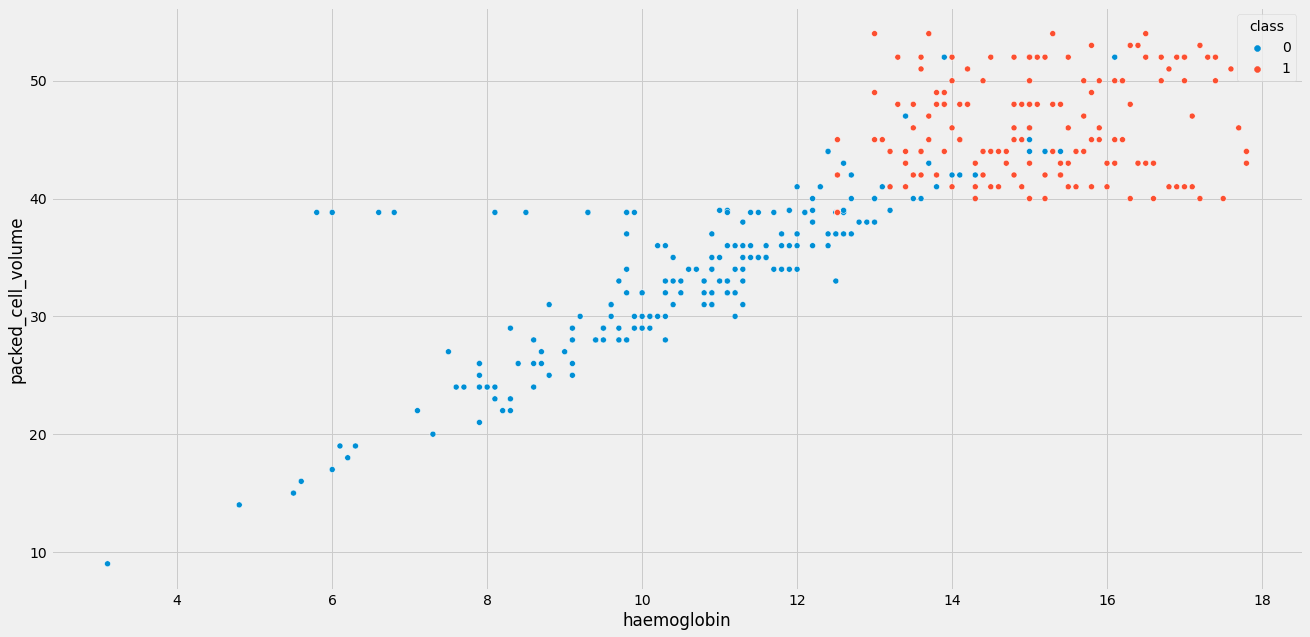

In [65]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=data, x='haemoglobin', y="packed_cell_volume", hue="class")
plt.show()

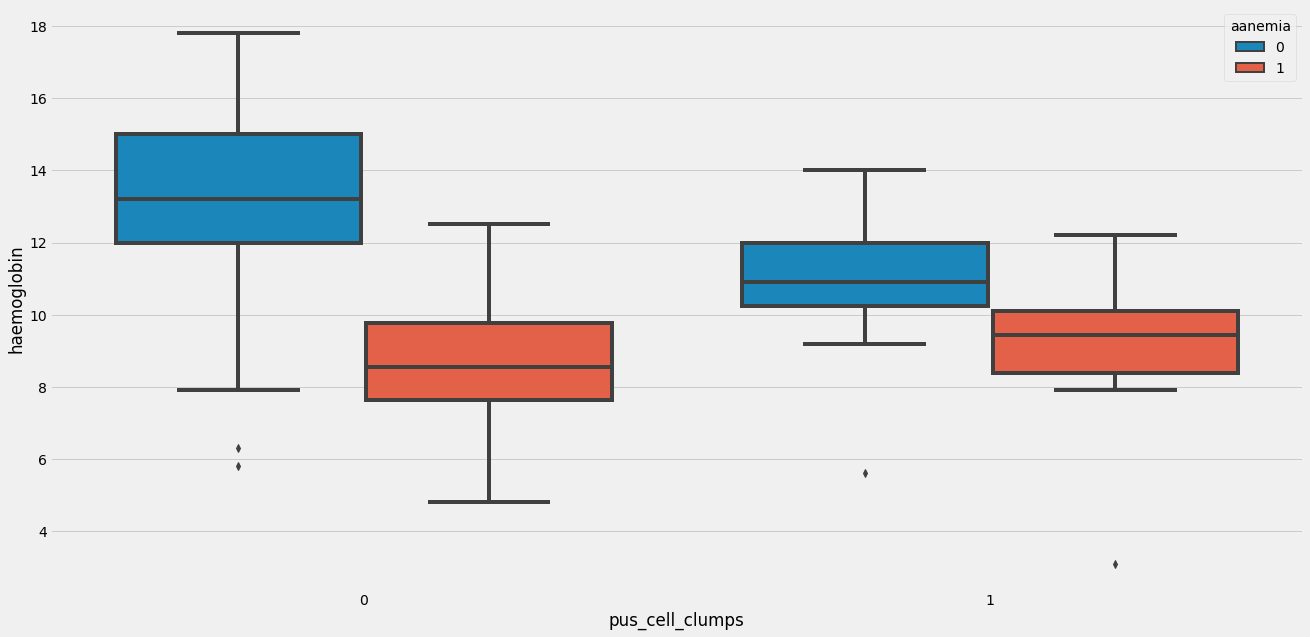

In [66]:
plt.figure(figsize=(20,10))
sns.boxplot(data=data, y='haemoglobin', x="pus_cell_clumps", hue="aanemia")
plt.show()

# Imputation & Scaling

So in the article, they do mention outlier/noise detection, though they dont really mention how they did that. 
2 options offer to use then:


**1- Outlier removal**


**2- Scaling using a method that is robust to outliers.**

So to avoid being too far off, we will deal with what we deem as outliers.

I'm in a bit of bind here because of 2 reasons:
First of all, the amount of outliers present here aren't high, and since its a classification model, they shouldnt be THAT big of a deal, however we are meant to "deal" with them and no method was specified. 
Secondly, Scaling alone using a RobustScaler(), which i'll explain later, should be more than enough for this dataset.

Okay so after some research, I decided **not** to delete those outliers, Instead I will scale using a robust scaling method.

To explain my resoning for this we need to explain why we remove outliers:

Outliers, in most cases, are values that are too far away, value wise, from the "center" of your data. 
In regression models, they are quite a pain since they reduce data correlation & therefore the performance of the model. 
**HOWEVER** 
In some case, such as this one, they are deemed as true outliers and they are actually healthy for model, given of course that you use the correct method of scaling and fitting. Since we checked correlation of the data earlier, we saw that there is no high correlation between the data to predict.

**AND THE MOST IMPORTANT NOTE** 
Our data is quite low, and we avoided removing as many lines as possible, and for some of the features, we might have to remove a big chunk, so I would much rather keep them and deal with them using scaling methods instead of using something like IQR(InterQuartileRange) to aggressively remove them.


However, we have to be careful which scaling method to use. 
Here's why:


A popular scaling method is MinMax scaling. Let's see how it fairs out when outliers exist.

In [67]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
#Creating a test dataframe 
test_df=pd.DataFrame(data)
test_df

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class
0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,121.000000,...,44.0,7800.0,5.200000,1,1,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,1,1,0,0,147.864407,...,38.0,6000.0,4.702247,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.000000,...,31.0,7500.0,4.702247,0,1,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.000000,...,32.0,6700.0,3.900000,1,0,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.000000,...,35.0,7300.0,4.600000,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.000000,...,47.0,6700.0,4.900000,0,0,0,0,0,0,1
393,42.0,70.0,1.025,0.0,0.0,1,1,0,0,75.000000,...,54.0,7800.0,6.200000,0,0,0,0,0,0,1
394,12.0,80.0,1.020,0.0,0.0,1,1,0,0,100.000000,...,49.0,6600.0,5.400000,0,0,0,0,0,0,1
395,17.0,60.0,1.025,0.0,0.0,1,1,0,0,114.000000,...,51.0,7200.0,5.900000,0,0,0,0,0,0,1


**Min-Max Scaling:**
We constrain all features between 0 and 1.
Minimum Age becomes 0, maximum Age (which is 80 for example) becomes 1.
Minimum "White Blood Cells (cells/cmm)" becomes 0, maximum "White Blood Cells (cells/cmm)" becomes 1.
And so on.
We do this by substracting the minimum and dividing by the maximum.

In [68]:
scaler = MinMaxScaler()
arr = scaler.fit_transform(test_df)
mm_scaled_data = pd.DataFrame(arr, columns=test_df.columns)
mm_scaled_data

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class
0,0.522727,0.230769,0.75,0.2,0.0,1.0,1.0,0.0,0.0,0.211538,...,0.777778,0.231405,0.525424,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.056818,0.000000,0.75,0.8,0.0,1.0,1.0,0.0,0.0,0.268941,...,0.644444,0.157025,0.441059,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.681818,0.230769,0.25,0.4,0.6,1.0,1.0,0.0,0.0,0.856838,...,0.488889,0.219008,0.441059,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.522727,0.153846,0.00,0.8,0.0,1.0,0.0,1.0,0.0,0.202991,...,0.511111,0.185950,0.305085,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,0.556818,0.230769,0.25,0.4,0.0,1.0,1.0,0.0,0.0,0.179487,...,0.577778,0.210744,0.423729,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.602273,0.230769,0.75,0.0,0.0,1.0,1.0,0.0,0.0,0.252137,...,0.844444,0.185950,0.474576,0.0,0.0,0.0,0.0,0.0,0.0,1.0
393,0.454545,0.153846,1.00,0.0,0.0,1.0,1.0,0.0,0.0,0.113248,...,1.000000,0.231405,0.694915,0.0,0.0,0.0,0.0,0.0,0.0,1.0
394,0.113636,0.230769,0.75,0.0,0.0,1.0,1.0,0.0,0.0,0.166667,...,0.888889,0.181818,0.559322,0.0,0.0,0.0,0.0,0.0,0.0,1.0
395,0.170455,0.076923,1.00,0.0,0.0,1.0,1.0,0.0,0.0,0.196581,...,0.933333,0.206612,0.644068,0.0,0.0,0.0,0.0,0.0,0.0,1.0


As we can see, all values are in [0,1] !
Let's test it out on a feature taht doesnt present that many outliers like Age and see the distribution.

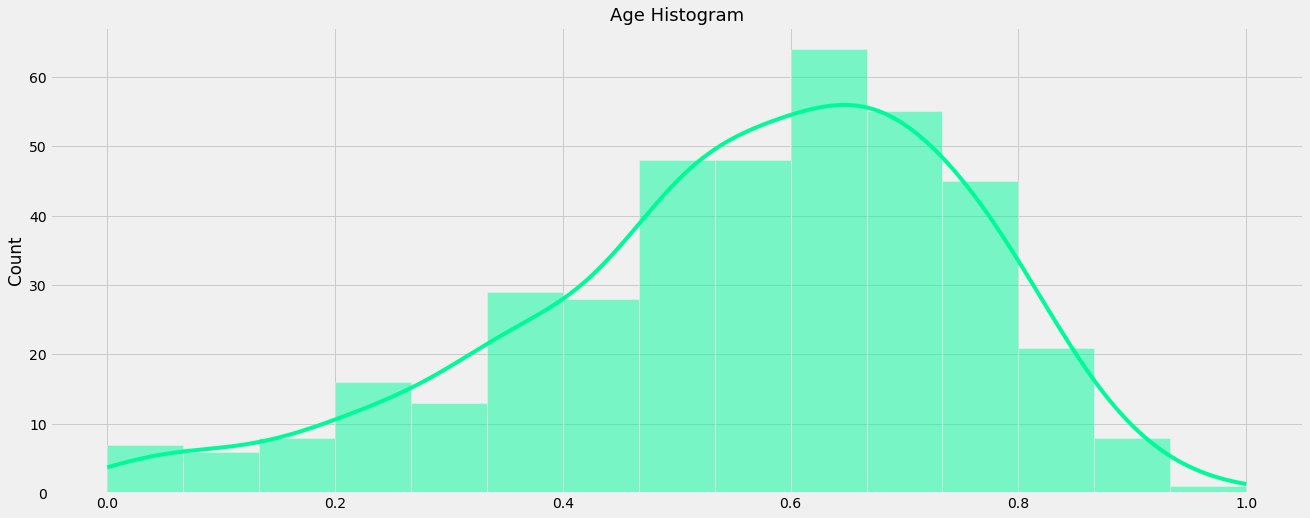

In [69]:
plt.figure(figsize=(20,8))
sns.histplot(data=mm_scaled_data, x="age", kde=True, color="mediumspringgreen")
plt.title("Age Histogram", fontsize=18)
plt.xlabel(None)
plt.show()

Now on a feature that presents outliers!

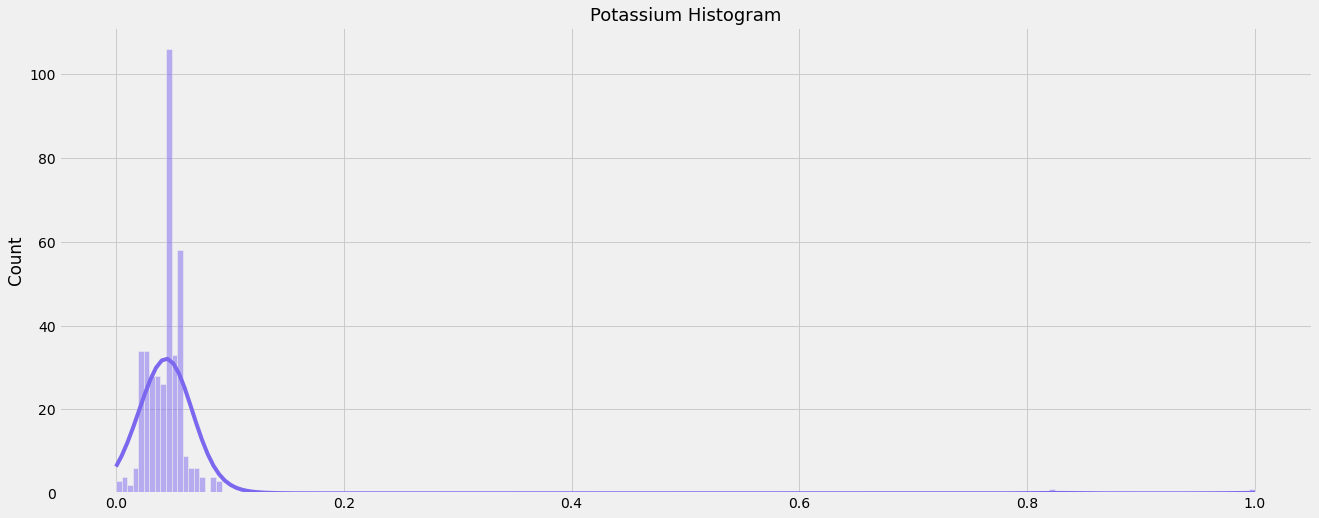

In [70]:
plt.figure(figsize=(20,8))
sns.histplot(data=mm_scaled_data, x="potassium", kde=True, color="mediumslateblue")
plt.title("Potassium Histogram", fontsize=18)
plt.xlabel(None)
plt.show()

Because of the outliers, almost all values are between 0 and 0.1, instead of 0 and 1.

Let's standardize our data then.

In [71]:
scaler = StandardScaler()
arr = scaler.fit_transform(test_df)
standardized_data = pd.DataFrame(arr, columns=test_df.columns)
standardized_data

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class
0,-0.204305,0.261949,0.417421,0.076874,-0.373561,0.36645,0.482617,-0.339365,-0.242212,-3.593066e-01,...,0.636275,-0.239366,0.592631,1.311174,1.393105,-0.306046,-0.510213,-0.482617,-0.421950,-0.775117
1,-2.627936,-1.962694,0.417421,2.365812,-0.373561,0.36645,0.482617,-0.339365,-0.242212,-3.801352e-16,...,-0.101097,-0.951772,0.000000,-0.762675,-0.717821,-0.306046,-0.510213,-0.482617,-0.421950,-0.775117
2,0.623276,0.261949,-1.423870,0.839854,2.572871,0.36645,0.482617,-0.339365,-0.242212,3.679889e+00,...,-0.961365,-0.358100,0.000000,-0.762675,1.393105,-0.306046,1.959965,-0.482617,2.369951,-0.775117
3,-0.204305,-0.479598,-2.344515,2.365812,-0.373561,0.36645,-2.072036,2.946681,-0.242212,-4.128058e-01,...,-0.838469,-0.674725,-0.955166,1.311174,-0.717821,-0.306046,1.959965,2.072036,2.369951,-0.775117
4,-0.026966,0.261949,-1.423870,0.839854,-0.373561,0.36645,0.482617,-0.339365,-0.242212,-5.599288e-01,...,-0.469783,-0.437257,-0.121737,-0.762675,-0.717821,-0.306046,-0.510213,-0.482617,-0.421950,-0.775117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.209485,0.261949,0.417421,-0.686105,-0.373561,0.36645,0.482617,-0.339365,-0.242212,-1.051850e-01,...,1.004961,-0.674725,0.235447,-0.762675,-0.717821,-0.306046,-0.510213,-0.482617,-0.421950,1.290128
393,-0.558983,-0.479598,1.338067,-0.686105,-0.373561,0.36645,0.482617,-0.339365,-0.242212,-9.745482e-01,...,1.865228,-0.239366,1.783245,-0.762675,-0.717821,-0.306046,-0.510213,-0.482617,-0.421950,1.290128
394,-2.332372,0.261949,0.417421,-0.686105,-0.373561,0.36645,0.482617,-0.339365,-0.242212,-6.401777e-01,...,1.250751,-0.714303,0.830754,-0.762675,-0.717821,-0.306046,-0.510213,-0.482617,-0.421950,1.290128
395,-2.036807,-1.221146,1.338067,-0.686105,-0.373561,0.36645,0.482617,-0.339365,-0.242212,-4.529303e-01,...,1.496542,-0.476835,1.426061,-0.762675,-0.717821,-0.306046,-0.510213,-0.482617,-0.421950,1.290128


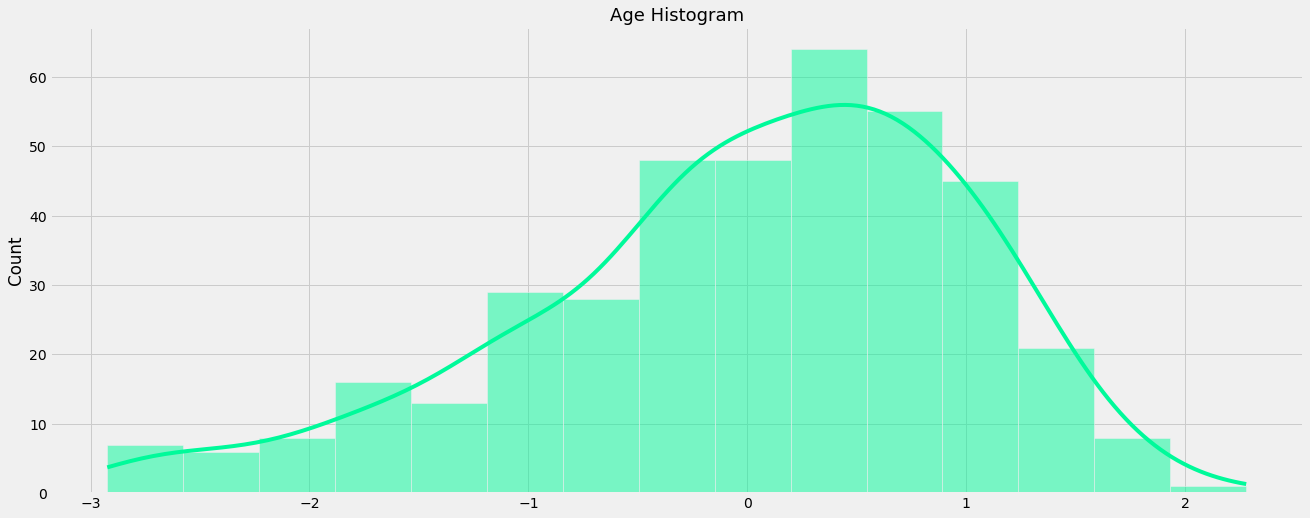

In [72]:
plt.figure(figsize=(20,8))
sns.histplot(data=standardized_data, x="age", kde=True, color="mediumspringgreen")
plt.title("Age Histogram", fontsize=18)
plt.xlabel(None)
plt.show()

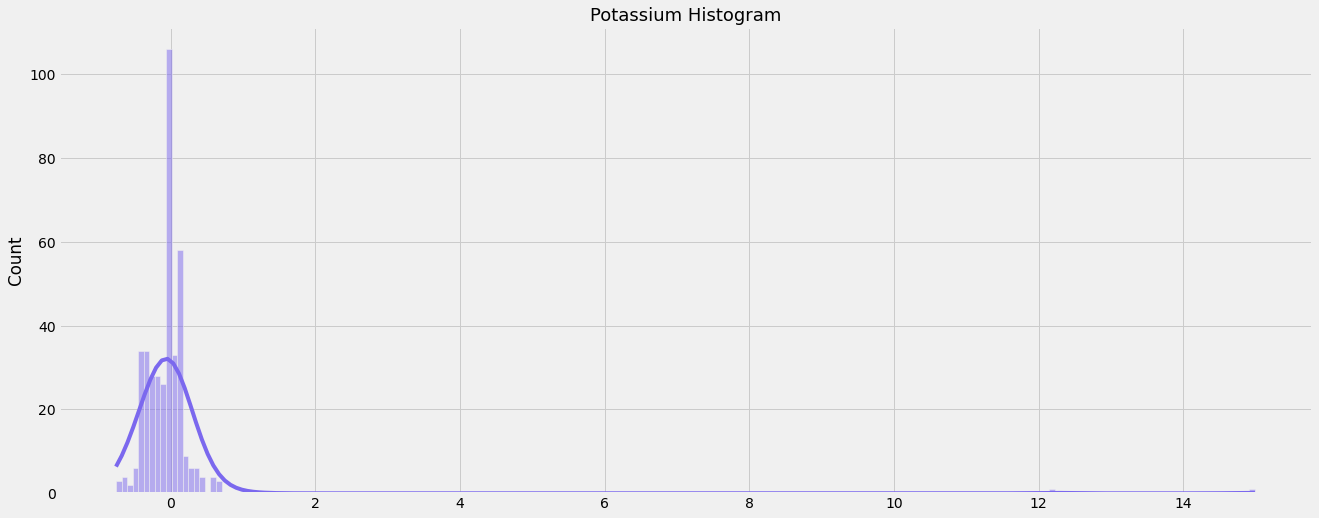

In [73]:
plt.figure(figsize=(20,8))
sns.histplot(data=standardized_data, x="potassium", kde=True, color="mediumslateblue")
plt.title("Potassium Histogram", fontsize=18)
plt.xlabel(None)
plt.show()

Big improvement here, since the values here are much closer to age then the one before that. However the data is still skewed which we do not want.

**Robust Scaling**
This is similar to standardization.
But instead of subtracting the mean, we substract the median.
And instead of dividing by the standard deviation, we divide by the inter-quartile range.
Which is the distance between the 25th percentile (also called first quartile) and the 75th percentile (third quartile).
**And??**
Contrary to the mean and the standard deviation, the median and the inter-quartile range aren't affected by outliers.
This scaling method isn't affected by outliers.
**But what happens to the features??**
This method ensures that all features will have a median of 0, and that 50% of the data points will be between -0.5 and 0.5.
Regardless of outliers.

In [74]:
scaler = RobustScaler()
arr = scaler.fit_transform(test_df)
rs_data = pd.DataFrame(arr, columns=test_df.columns)
rs_data

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class
0,-0.272727,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,-0.081633,...,0.517737,-0.251998,0.829588,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-2.136364,-3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.466621,...,-0.082263,-1.001998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.363636,0.0,-2.0,1.0,3.0,0.0,0.0,0.0,0.0,6.081633,...,-0.782263,-0.376998,0.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.272727,-1.0,-3.0,2.0,0.0,0.0,-1.0,1.0,0.0,-0.163265,...,-0.682263,-0.710331,-1.337079,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,-0.136364,0.0,-2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.387755,...,-0.382263,-0.460331,-0.170412,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.306122,...,0.817737,-0.710331,0.329588,0.0,0.0,0.0,0.0,0.0,0.0,1.0
393,-0.545455,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.020408,...,1.517737,-0.251998,2.496255,0.0,0.0,0.0,0.0,0.0,0.0,1.0
394,-1.909091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.510204,...,1.017737,-0.751998,1.162921,0.0,0.0,0.0,0.0,0.0,0.0,1.0
395,-1.681818,-2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.224490,...,1.217737,-0.501998,1.996255,0.0,0.0,0.0,0.0,0.0,0.0,1.0


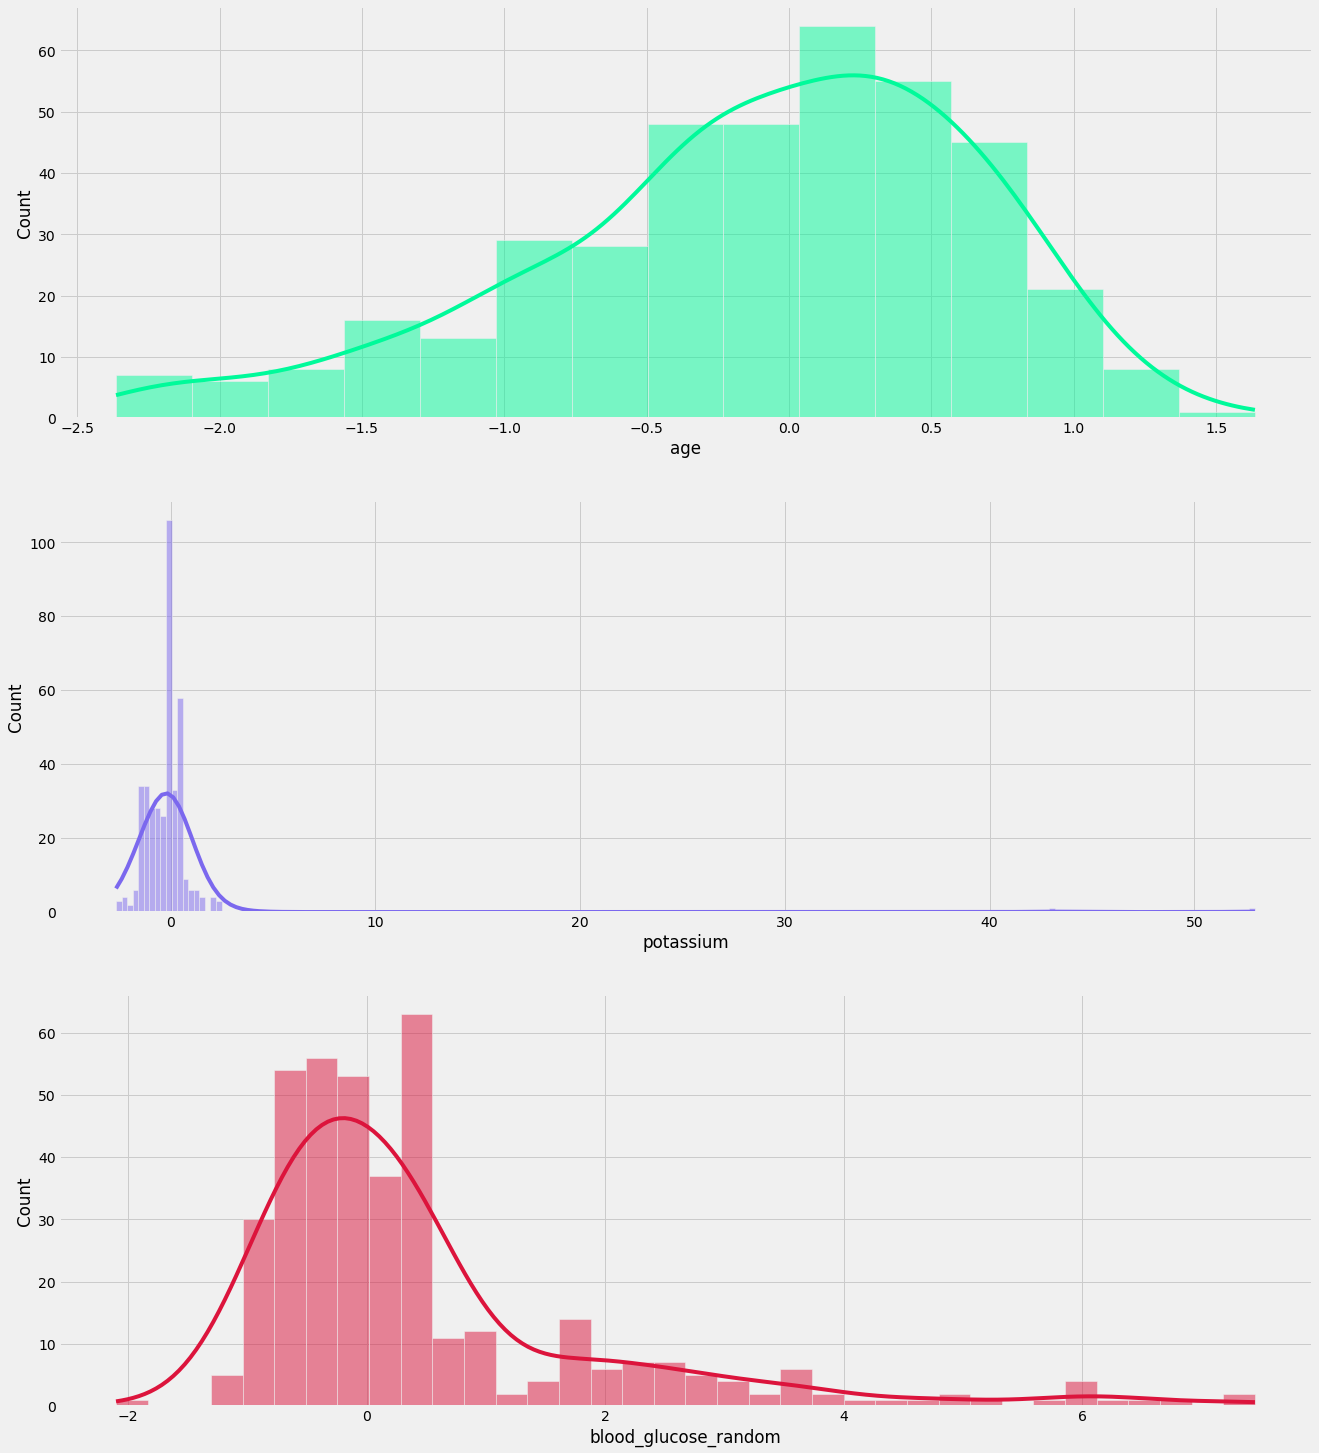

In [75]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,24))
sns.histplot(data=rs_data, x="age", kde=True, color="mediumspringgreen", ax=axes[0])
sns.histplot(data=rs_data, x="potassium", kde=True, color="mediumslateblue", ax=axes[1])
sns.histplot(data=rs_data, x="blood_glucose_random", kde=True, color="crimson", ax=axes[2])
plt.show()

As you can see all features have 50% of their values between -0.5 and 0.5.
The remaining values don't get much farther from 0 either.
Outliers do, but there aren't many of them.
Plus, we want features to be on the same scale for most of their values, so a few points situated far from the common scale won't bother.

# ARTICLE ENDS HERE! 
All that's left is feature selection & model fitting. 
Thank you for following this and I hope you found this helpful! :D